In [1]:
%load_ext pycodestyle_magic
%flake8_on

In [2]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, \
                            precision_score, recall_score
import xgboost as xgb
import lightgbm as lgb

from reduce_mem_usage import reduce_mem_usage

pd.set_option('max_columns', 100)
pd.set_option('max_rows', 1000)

# Get data

In [3]:
X_train = pd.read_csv('input/X_train.csv')
X_valid = pd.read_csv('input/X_valid.csv')

X_train.shape, X_valid.shape

((413378, 435), (88581, 435))

In [5]:
y_train = X_train['isFraud'].copy()
y_valid = X_valid['isFraud'].copy()

del(X_train['isFraud'])
del(X_valid['isFraud'])

# Funcs

In [6]:
def results(m, X_train=X_train, y_train=y_train,
            X_valid=X_valid, y_valid=y_valid):
    preds_train = m.predict(X_train)
    preds_valid = m.predict(X_valid)
    res = {'train_recall': recall_score(y_train, preds_train.round()),
           'valid_recall': recall_score(y_valid, preds_valid.round()),
           'train_precision': precision_score(y_train, preds_train.round()),
           'valid_precision': precision_score(y_valid, preds_valid.round()),
           'train_f1': f1_score(y_train, preds_train.round()),
           'valid_f1': f1_score(y_valid, preds_valid.round()),
           'train_roc': roc_auc_score(y_train, preds_train),
           'valid_roc': roc_auc_score(y_valid, preds_valid)
           }
    return res

# Model

In [8]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.5,
    tree_method='gpu_hist',
    njobs=8
)
clf.fit(X_train, y_train)

In [14]:
results(clf)

{'train_recall': 0.7110352673492605,
 'valid_recall': 0.4014814814814815,
 'train_precision': 0.9911195686647637,
 'valid_precision': 0.846875,
 'train_f1': 0.8280339162692103,
 'valid_f1': 0.5447236180904523,
 'train_roc': 0.8554020217261354,
 'valid_roc': 0.6995996135865722}

In [ ]:
lgb_params = {'objective': 'binary',
              'boosting_type': 'gbdt',
              'metric': 'auc',
              'n_jobs': 8,
              'learning_rate': 0.01,
              'num_leaves': 496,
              'max_depth': -1,
              'tree_learner': 'serial',
              'colsample_bytree': 0.7,
              'subsample_freq': 1,
              'subsample': 0.7,
              'n_estimators': 800,
              'max_bin': 255,
              'verbose': -1,
              'seed': 24,
              'early_stopping_rounds': 100
              }

In [9]:
tr_data = lgb.Dataset(X_train, label=y_train)
vl_data = lgb.Dataset(X_valid, label=y_valid) 


estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets=[tr_data, vl_data],
        verbose_eval=100,
)

C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\benjamin.dubreu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.953615	valid_1's auc: 0.902259
[200]	training's auc: 0.976622	valid_1's auc: 0.915772
[300]	training's auc: 0.991916	valid_1's auc: 0.925325
[400]	training's auc: 0.997417	valid_1's auc: 0.930708
[500]	training's auc: 0.999104	valid_1's auc: 0.933544
[600]	training's auc: 0.999691	valid_1's auc: 0.934629
[700]	training's auc: 0.999891	valid_1's auc: 0.935442
[800]	training's auc: 0.99996	valid_1's auc: 0.935741
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.99996	valid_1's auc: 0.935741


20:46: W291 trailing whitespace


In [10]:
results(estimator)

{'train_recall': 0.9017058742605585,
 'valid_recall': 0.35009861932938857,
 'train_precision': 0.9992377467794802,
 'valid_precision': 0.8934563758389261,
 'train_f1': 0.9479697725711392,
 'valid_f1': 0.5030703826169107,
 'train_roc': 0.9999596177242522,
 'valid_roc': 0.9357411311567176}

# Try subsamples to see until when I get similar score 

In [11]:
X_subsample = pd.concat([X_train[y_train == 0].sample(frac=0.2),
                         X_train[y_train == 1]])
X_subsample = X_subsample.sample(frac=1)
y_subsample = y_train[X_subsample.index]
assert len(X_subsample) == len(y_subsample)
assert (X_subsample.index == y_subsample.index).all()

## subsample 0.2 + XGB

In [ ]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.5,
    tree_method='gpu_hist',
    njobs=8
)
clf.fit(X_subsample, y_subsample)

In [9]:
results(clf, X_subsample, y_subsample)

{'train_recall': 0.8382821387940842,
 'valid_recall': 0.5422222222222223,
 'train_precision': 0.9899905951901116,
 'valid_precision': 0.6208651399491094,
 'train_f1': 0.9078420501447668,
 'valid_f1': 0.578884934756821,
 'train_roc': 0.9183720450772931,
 'valid_roc': 0.765906173989546}

## subsample 0.2 + Light GBM

In [6]:
tr_data = lgb.Dataset(X_subsample, label=y_subsample)
vl_data = lgb.Dataset(X_valid, label=y_valid) 

estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets=[tr_data, vl_data],
        verbose_eval=100,
)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.954606	valid_1's auc: 0.903407
[200]	training's auc: 0.973589	valid_1's auc: 0.91672
[300]	training's auc: 0.987499	valid_1's auc: 0.927227
[400]	training's auc: 0.994493	valid_1's auc: 0.931656
[500]	training's auc: 0.997656	valid_1's auc: 0.933709
[600]	training's auc: 0.999083	valid_1's auc: 0.935308
[700]	training's auc: 0.999684	valid_1's auc: 0.935653
[800]	training's auc: 0.999901	valid_1's auc: 0.936202
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999901	valid_1's auc: 0.936202


In [13]:
results(estimator, X_subsample, y_subsample)

{'train_recall': 0.9512514220705347,
 'valid_recall': 0.5281481481481481,
 'train_precision': 0.9986861749776053,
 'valid_precision': 0.6360392506690455,
 'train_f1': 0.9743918426802621,
 'valid_f1': 0.5770942938081749,
 'train_roc': 0.9999006687929789,
 'valid_roc': 0.9362015732546707}

## subsample 0.1 + XGB

In [11]:
X_subsample2 = pd.concat([X_train[ y_train == 0].sample(frac=0.1),
                          X_train[ y_train == 1]])
X_subsample2 = X_subsample2.sample(frac=1)
y_subsample2 = y_train[X_subsample2.index]
assert len(X_subsample2) == len(y_subsample2)
assert (X_subsample2.index == y_subsample2.index).all()

In [12]:
clf = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=9,
    learning_rate=0.05,
    subsample=0.5,
    colsample_bytree=0.5,
    tree_method='gpu_hist',
    njobs=8
)
clf.fit(X_subsample2, y_subsample2)
results(clf, X_subsample2, y_subsample2)

{'train_recall': 0.892320819112628,
 'valid_recall': 0.6303703703703704,
 'train_precision': 0.9872868021901945,
 'valid_precision': 0.41593352883675466,
 'train_f1': 0.9374047626161522,
 'valid_f1': 0.5011778563015313,
 'train_roc': 0.9440752697900148,
 'valid_roc': 0.8012704203971088}

## subsample 0.1 + Light GBM

In [16]:
tr_data = lgb.Dataset(X_subsample2, label=y_subsample2)
vl_data = lgb.Dataset(X_valid, label=y_valid) 


estimator = lgb.train(
        lgb_params,
        tr_data,
        valid_sets=[tr_data, vl_data],
        verbose_eval=100,
)

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.960179	valid_1's auc: 0.90436
[200]	training's auc: 0.976637	valid_1's auc: 0.916137
[300]	training's auc: 0.988695	valid_1's auc: 0.925036
[400]	training's auc: 0.995103	valid_1's auc: 0.930112
[500]	training's auc: 0.998102	valid_1's auc: 0.932445
[600]	training's auc: 0.999384	valid_1's auc: 0.933389
[700]	training's auc: 0.999834	valid_1's auc: 0.933806
[800]	training's auc: 0.999967	valid_1's auc: 0.934124
Did not meet early stopping. Best iteration is:
[800]	training's auc: 0.999967	valid_1's auc: 0.934124


In [ ]:
results(estimator, X_subsample, y_subsample)

{'train_recall': 0.9796359499431172,
 'valid_recall': 0.6125925925925926,
 'train_precision': 0.9060872310201504,
 'valid_precision': 0.4384941675503712,
 'train_f1': 0.9414272829146966,
 'valid_f1': 0.511124845488257,
 'train_roc': 0.9974787486211453,
 'valid_roc': 0.9341235315427212}

# Preliminary feature importance

<BarContainer object of 18 artists>

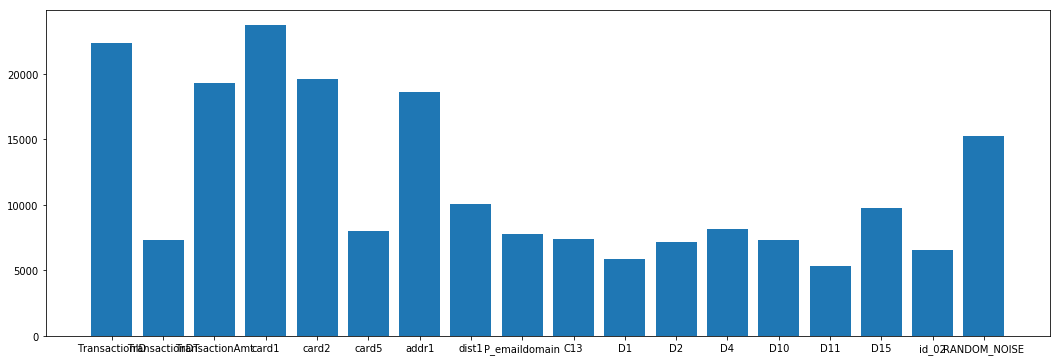

In [32]:
plt.figure(figsize=(18,6))
mask = (estimator.feature_importance() > 5000)
plt.bar(X_subsample.columns[mask],
        estimator.feature_importance()[mask])

<BarContainer object of 21 artists>

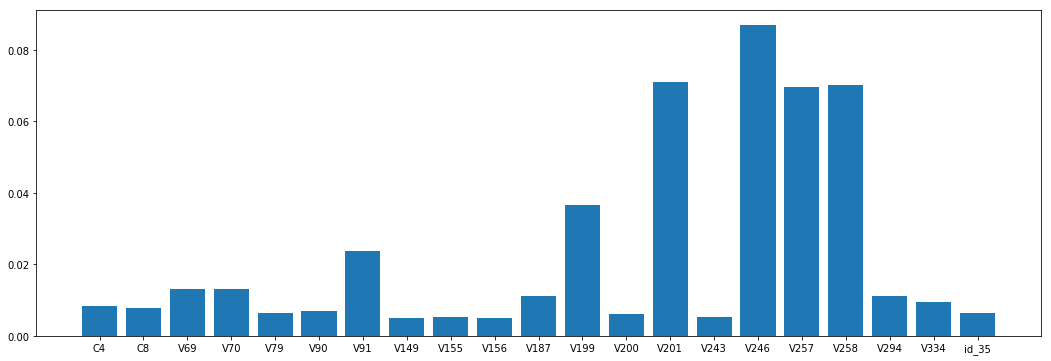

In [38]:
plt.figure(figsize=(18,6))
plt.bar(X_subsample.columns[clf.feature_importances_ > 0.005],
        clf.feature_importances_[clf.feature_importances_ > 0.005])

# Quick analysis of top 'V' features

In [55]:
X_subsample2['V246'].describe()

count    19156.000000
mean         1.693882
std          2.239450
min          0.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         45.000000
Name: V246, dtype: float64

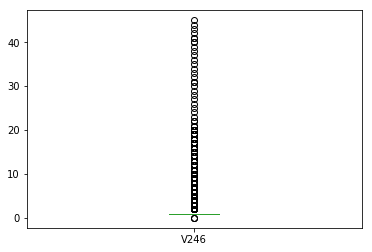

In [56]:
X_subsample2['V246'].plot(kind='box')

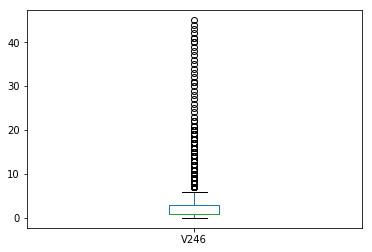

In [63]:
X_subsample2[y_subsample2 == 1]['V246'].plot(kind='box')

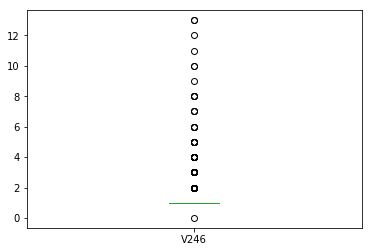

In [64]:
X_subsample2[y_subsample2 == 0]['V246'].plot(kind='box')

In [62]:
X_subsample2[y_subsample2 == 1]['V246'].value_counts()

1.0     4718
2.0     1600
3.0      759
4.0      441
5.0      282
6.0      212
7.0      159
8.0       79
9.0       65
10.0      49
11.0      34
12.0      28
14.0      22
13.0      22
16.0      19
15.0      16
17.0      16
18.0      10
20.0       9
19.0       7
31.0       3
21.0       3
22.0       3
41.0       2
0.0        2
40.0       2
30.0       1
32.0       1
38.0       1
37.0       1
35.0       1
23.0       1
28.0       1
24.0       1
36.0       1
27.0       1
25.0       1
34.0       1
42.0       1
26.0       1
44.0       1
45.0       1
29.0       1
43.0       1
33.0       1
39.0       1
Name: V246, dtype: int64

In [61]:
X_subsample2[y_subsample2 == 0]['V246'].value_counts()

1.0     10061
2.0       407
3.0        65
4.0        15
5.0         7
6.0         4
8.0         4
7.0         3
13.0        2
10.0        2
12.0        1
11.0        1
9.0         1
0.0         1
Name: V246, dtype: int64